In [17]:
import cooperpairbox as cpb
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
from pprint import pprint

In [18]:
def pair_max(x):
    # x is an array or list
    x1 = x[:-1] # all except last element
    x2 = x[1:]  # all except first element
    # compare the two shifted arrays and compute the maximum for normalization
    return np.maximum(x1,x2)

In [19]:
# Instantiate the CPB object

CPB = cpb.Hcpb()
# nothing gets computed until noth Ej and Ec are set, this can either be done
# at instantiation or by calling the property
# It does create the matrix elements though for the number of levels 
# of the charge basis defined (default: 15,  n = [-15, 15])
# Upon changing nlevels the matrix elements are recalculated otherwise they are
# calculated once to save time

pprint(CPB.Ej)
pprint(CPB.Ec)
pprint(CPB.evals)
pprint(CPB.evecs)
pprint(CPB.Ic)
pprint(CPB.Rn)

None
None
None
None
None
None


In [20]:
# Take that same object from previously and set the Ej and Ec properties
EjEc = 60
Ec = 0.2   # GHz
CPB.Ej = EjEc * Ec
# Ec isn't assigned yet
pprint(CPB.Ej)
pprint(CPB.Ec)
pprint(CPB.evals)
pprint(CPB.evecs)
pprint(CPB.Ic)
pprint(CPB.Rn)


12.0
None
None
None
None
None


In [21]:
EjEc = 60
Ec = 0.2
CPB.Ej = EjEc * Ec
# Now we will actually have some values
CPB.Ec = Ec
pprint(CPB.Ej)
pprint(CPB.Ec)
# pprint(CPB.evals)  # Produce long outputs supress for now
# pprint(CPB.evecs)  #          ""
pprint(CPB.Ic)
pprint(CPB.Rn)

12.0
0.2
2.4160254235897565e-08
11572.798176687078


In [22]:
# Several utility functions to make life easier

f01 = CPB.fij(0, 1) # Calculate arbitrary transition frequencies between levels
eta = CPB.anharm()  # Calculate the anharmonicity

n01 = CPB.n_ij(0, 1) # Calculate the charge matrix element between levels (i, j)

H_0 = CPB.h0_to_qutip(5) # Create a qutip Hamiltonian object up to a truncation levle of the transmon
H_n0 = CPB.n_to_qutip(5, thresh=1e-10) # Create the charge operator up to a truncation levle of the transmon and a threshold for small values



In [23]:
# On the fly updating of the hamiltonian by changing any property of the system
CPB.Ej = 40 * Ec
print(CPB.fij(0,1))
# Most expensive change is to change nlevels which recreates the matrix elements
# and expands the number of charge states.

3.3644169483476247


In [24]:
# Suppose you have a measured spectrum with f01 and anharmonicity and you want to back
# out the Ej and Ec values.  You can do this by creating a model and inputting the data
# It will optimize over Ej and Ec to converge on the measured spectrum

Ej_extracted, Ec_extracted = CPB.params_from_spectrum(4.56712344, 0.213456721)
print(Ej_extracted, Ec_extracted)

14.803293628019516 0.1919465860966093


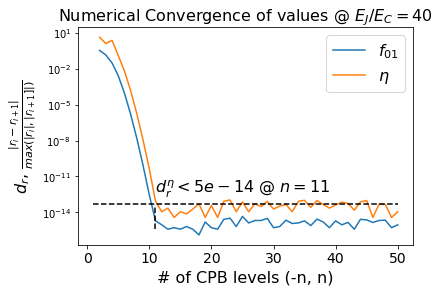

In [39]:
# Performance metrics
# Convergence on the number of charge states

# How many states do you need to include to reach a certain numerical precision
nlevels = np.arange(1, 51)    # [-n, n]
CPB = cpb.Hcpb()
EjEc = 40 # Some test values
Ec = 0.2
CPB.Ej = EjEc * Ec
CPB.Ec = Ec

f01_list = []
eta_list = []

for level in nlevels:
    CPB.nlevels = level # setter changes the number of charge states and recomputes properties
    f01_list.append(CPB.fij(0, 1))
    eta_list.append(CPB.anharm())
f01_list = np.array(f01_list)
eta_list = np.array(eta_list)


df01 = np.diff(f01_list)
deta = np.diff(eta_list)

max_df01 = np.abs(pair_max(f01_list)) # normalization condition
max_deta = np.abs(pair_max(eta_list)) # normalization condition

plt.plot(nlevels[1:], np.abs(df01)/max_df01, label=r'$f_{01}$')
plt.plot(nlevels[1:], np.abs(deta)/max_deta, label=r'$\eta$')
plt.ylabel(r'$d_r$, $\frac{|r_i - r_{i+1}|}{max(|r_i|,|r_{i+1}]|)}$',
           fontsize=16)
plt.xlabel(r'# of CPB levels (-n, n)', fontsize=16)
plt.title(r'Numerical Convergence of values @ $E_J/E_C=40$', fontsize=16)
plt.xticks(size=14)

plt.legend(fontsize=16)
plt.plot([1, 50], [5e-14]*2, '--k')
plt.plot([11]*2, [0.4e-15, 4e-14], '--k')
plt.annotate(r'$d_r^{\eta} < 5e-14$ @ $n=11$', (11, 0.4e-12), (11, 0.4e-12), fontsize=16)

plt.yscale('log')

In [50]:
# Check how this scales as a function of Ej/Ec
EjEc = np.linspace(0.1, 200.1, 201)
CPB = cpb.Hcpb()
nlevels = np.arange(1, 26)

Ec = 0.2

f01_list = []
eta_list = []

CPB.Ec = Ec
for ejec in EjEc:
    CPB.Ej = ejec * Ec
    f01_temp = []
    eta_temp = []
    for level in nlevels:
        CPB.nlevels = level
        f01_temp.append(CPB.fij(0, 1))
        eta_temp.append(CPB.anharm())
    f01_list.append(f01_temp)
    eta_list.append(eta_temp)

f01_list = np.array(f01_list)
eta_list = np.array(eta_list)


n_f01 = [] # Store the number of levels for f01 convergence
n_eta = [] # Store the number of levels for eta convergence

for i in range(len(EjEc)):
    df01 = np.diff(f01_list[i, :])
    deta = np.diff(eta_list[i, :])

    max_df01 = np.abs(pair_max(f01_list[i, :])) # normalization condition
    max_deta = np.abs(pair_max(eta_list[i, :])) # normalization condition

    rel_f01 = np.abs(df01)/max_df01
    rel_eta = np.abs(deta)/max_deta

    n_f01.append(np.argmax(rel_f01 < 1e-12))
    n_eta.append(np.argmax(rel_eta < 1e-12))

n_f01 = np.array(n_f01)
n_eta = np.array(n_eta)

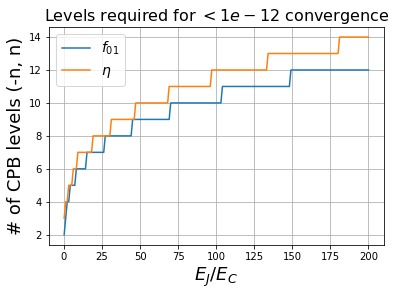

In [59]:
plt.plot(EjEc, n_f01, label=r'$f_{01}$')
plt.plot(EjEc, n_eta, label=r'$\eta$')
plt.title(r'Levels required for $<1e-12$ convergence', fontsize=16)
plt.xlabel(r'$E_{J}/E_{C}$',  fontsize=18)
plt.ylabel(r'# of CPB levels (-n, n)', fontsize=18)
plt.legend(fontsize=14)
plt.grid()

(4, 501, 5)
(4, 501, 5)


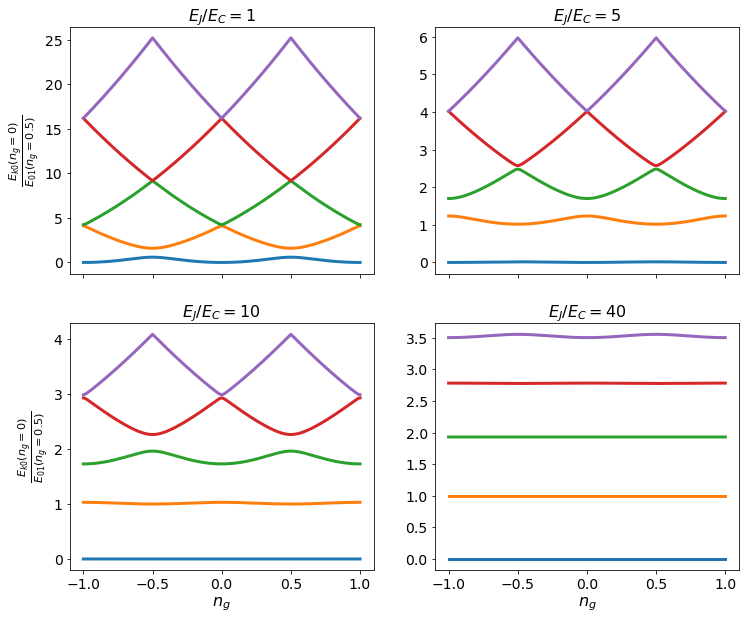

In [61]:
# Quickly compute the charge landscape

ng_list = np.linspace(-1, 1, 501)
EjEc_list = np.array([1, 5, 10, 40])

Ec = 0.2
n_levels = 11
CPB = cpb.Hcpb(nlevels=n_levels, Ec=Ec)

evals = []

k = 5 # Number of levels to extract

for ejec in EjEc_list:
    Ej = ejec*Ec
    CPB.Ej = Ej
    eval_temp = []
    for ng in ng_list:
        CPB.ng = ng
        eval_temp.append(CPB.evals[:k])
    evals.append(eval_temp)

evals = np.array(evals)
print(evals.shape)

evals_gnd = np.tile(evals[:, len(ng_list)//2, 0], (5, 501, 1))
evals_gnd = np.swapaxes(evals_gnd, 0, 2)
# evals_gnd = np.swapaxes(evals_gnd, 1, 2)
evals_new = evals - evals_gnd
print(evals_new.shape)
evals_f01 = np.tile(evals[:, len(ng_list)//4, 1], (5, 501, 1)) - np.tile(evals[:, len(ng_list)//4, 0], (5, 501, 1))
evals_f01 = np.swapaxes(evals_f01, 0, 2)
evals_new = evals_new/evals_f01 # Normalize to f01

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 10))

for i in range(2):
    for j in range(2):
        ax[i, j].plot(ng_list, 
                      evals_new[int('{}{}'.format(i,j),2), :, :],
                      lw=3)
        ax[i, j].set_title(r'$E_J/E_C={}$'.format(EjEc_list[int('{}{}'.format(i,j),2)]),
                           fontsize=16)
        ax[i, j].tick_params(labelsize=14)
_ = ax[0,0].set_ylabel(r'$\frac{E_{k0}(n_g=0)}{E_{01}(n_g=0.5)}$', fontsize=16)
_ = ax[1,0].set_ylabel(r'$\frac{E_{k0}(n_g=0)}{E_{01}(n_g=0.5)}$', fontsize=16)
_ = ax[1,0].set_xlabel(r'$n_g$', fontsize=16)
_ = ax[1,1].set_xlabel(r'$n_g$', fontsize=16) 

Text(0.5, 0.98, '$E_J/E_C=40$, $n_g = 0.5$')

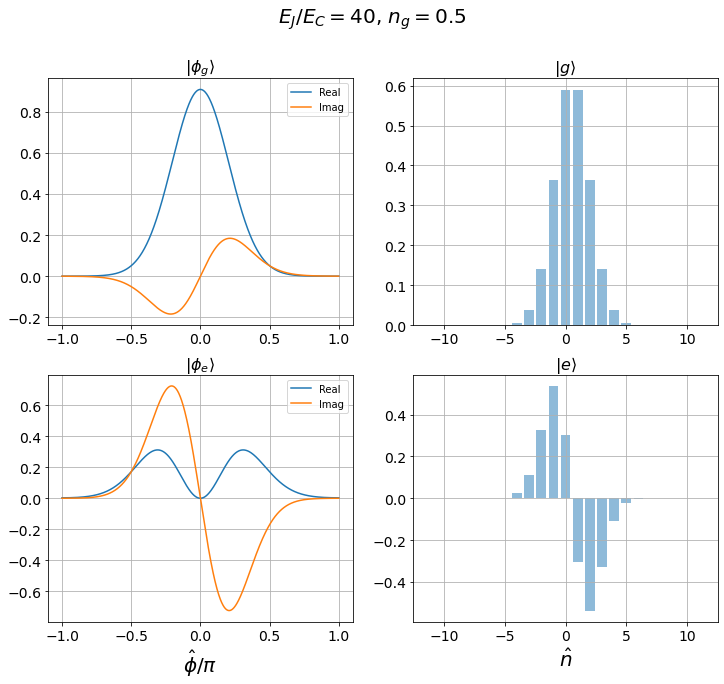

In [101]:
# Plot the phi wavefunctions and the charge wavefunctions by taking the fourier transform of the
# charge states of the transmon
pts = 1001
phi = np.linspace(-np.pi, np.pi, pts)
n = np.arange(-11, 12)
CPB = cpb.Hcpb(nlevels=11, Ec=0.2, Ej=40*0.2, ng=0.5)
gnd_charge = CPB.evec_k(0)
gnd_phi = CPB.psi_k(0, pts=pts)
e_charge = CPB.evec_k(1)
e_phi = CPB.psi_k(1, pts=pts)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0][0].plot(phi/np.pi, gnd_phi.real, label='Real')
ax[0][0].plot(phi/np.pi, gnd_phi.imag, label='Imag')
_ = ax[0][0].set_title(r'$|\phi_g\rangle$', fontsize=16)
_ = ax[0][0].legend()
_ = ax[0][0].grid()
_ = ax[0][0].tick_params(axis='both', labelsize=14)

ax[1][0].plot(phi/np.pi, e_phi.real, label='Real')
ax[1][0].plot(phi/np.pi, e_phi.imag, label='Imag')
ax[1][0].set_title(r'$|\phi_e\rangle$', fontsize=16)
_ = ax[1][0].legend()
_ = ax[1][0].grid()
_ = ax[1][0].tick_params(axis='both', labelsize=14)
_ = ax[1][0].set_xlabel(r'$\hat{\phi}/\pi$', fontsize=20)


ax[0][1].bar(n, gnd_charge.real, label='Real', alpha=0.5)
ax[0][1].bar(n, gnd_charge.imag, label='Imag', alpha=0.5)
_ = ax[0][1].set_title(r'$|g\rangle$', fontsize=16)
_ = ax[0][1].grid()
_ = ax[0][1].tick_params(axis='both', labelsize=14)


ax[1][1].bar(n, e_charge.real, label='Real', alpha=0.5)
ax[1][1].bar(n, e_charge.imag, label='Imag', alpha=0.5)
ax[1][1].set_title(r'$|e\rangle$', fontsize=16)
_ = ax[1][1].grid()
_ = ax[1][1].set_xlabel(r'$\hat{n}$', fontsize=20)
_ = ax[1][1].tick_params(axis='both', labelsize=14)

fig.suptitle(r'$E_J/E_C=40$, $n_g = 0.5$', fontsize=20)

